# Brain Tumor Multi-Task Learning
**Classification + Segmentation**

- Encoder: EfficientNet-B3 (pretrained ImageNet)
- Decoder: U-Net with CBAM Attention
- Tasks: 4-class classification + Binary segmentation

## 1. Imports & Configuration

In [1]:
!pip install -q segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.4 MB/s eta 0:00:00


In [2]:
import os, gc, warnings
from typing import Dict, List, Tuple, Optional
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
#   Cấu hình
class Config:
    ROOT_DIR = '/kaggle/input/brisc2025/brisc2025'
    CLASS_DIR = os.path.join(ROOT_DIR, 'classification_task')
    SEG_DIR = os.path.join(ROOT_DIR, 'segmentation_task')
    CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    NUM_CLASSES = 4
    IMG_SIZE = 320
    BATCH_SIZE_STAGE1, BATCH_SIZE_STAGE2 = 32, 16
    EPOCHS_STAGE1, EPOCHS_STAGE2 = 10, 50
    PATIENCE = 15
    ENCODER_NAME = "efficientnet-b3"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    @classmethod
    def class_to_idx(cls): return {name: i for i, name in enumerate(cls.CLASSES)}
    @classmethod
    def idx_to_class(cls): return {i: name for i, name in enumerate(cls.CLASSES)}

def set_seed(seed=42):
    np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(Config.SEED)
print(f"Device: {Config.DEVICE}")

Device: cuda


## 2. Data Preparation

In [4]:
# Tạo DataFrame chứa thông tin về ảnh, mask và label
def create_dataframe(mode='train'):
    class_path = os.path.join(Config.CLASS_DIR, mode)
    seg_mask_path = os.path.join(Config.SEG_DIR, mode, 'masks')
    mask_basenames = set()
    if os.path.exists(seg_mask_path):
        mask_basenames = {os.path.splitext(f)[0] for f in os.listdir(seg_mask_path)}
    data = []
    # Duyệt qua từng class folder
    for cls_name in Config.CLASSES:
        cls_folder = os.path.join(class_path, cls_name)
        if not os.path.exists(cls_folder): continue 
        # DUYỆT QUA TẤT CẢ ẢNH TRONG CLASS FOLDER 
        for img_name in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_name)
            img_base = os.path.splitext(img_name)[0]
             # TÌM MASK TƯƠNG ỨNG 
            mask_path = "NO_MASK"
            if img_base in mask_basenames:
                for ext in ['.png', '.jpg']:
                    candidate = os.path.join(seg_mask_path, img_base + ext)
                    if os.path.exists(candidate): mask_path = candidate; break
             # THÊM VÀO DATA LIST
            data.append({'image_path': img_path, 'mask_path': mask_path, 
                        'label': Config.class_to_idx()[cls_name], 'filename': img_name})
    return pd.DataFrame(data)
    
# Chuẩn bị dữ liệu: Tạo train/val/test dataframes
def prepare_data():
    train_full = create_dataframe('train')
    test_df = create_dataframe('test')
    train_df, val_df = train_test_split(train_full, test_size=0.2, stratify=train_full['label'], random_state=Config.SEED)
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df

train_df, val_df, test_df = prepare_data()

Train: 4000, Val: 1000, Test: 1000


## 3. Dataset & Augmentation

In [5]:
#  Custom PyTorch Dataset cho Brain Tumor Classification + Segmentation
class BRISCDataset(Dataset):
    # Khởi tạo dataset
    def __init__(self, df, transforms=None):
        self.df, self.transforms = df, transforms
    # Trả về số lượng samples trong dataset
    def __len__(self): return len(self.df)
        
    # Load và preprocess 1 sample tại index idx
    def __getitem__(self, idx):
        row = self.df.iloc[idx] 
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB) # Đọc ảnh từ file và chuyển BGR → RGB
        h, w = image.shape[:2] # height, width
        
        # Không có mask → Tạo mask toàn 0 (background)
        if row['mask_path'] == 'NO_MASK' or pd.isna(row['mask_path']):
            mask = np.zeros((h, w), dtype=np.float32)   # Không có mask → Tạo mask toàn 0 (background)
        else:
            # Có mask → Load từ file
            mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
            mask = (mask.astype(np.float32) / 255.0 > 0.5).astype(np.float32) 
        # APPLY AUGMENTATION 
        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        
        if isinstance(mask, torch.Tensor):
            mask = mask.unsqueeze(0) if mask.ndim == 2 else mask
        else:
            mask = torch.from_numpy(mask).unsqueeze(0)
        
        return image, mask, torch.tensor(row['label'], dtype=torch.long)

In [ ]:
def get_train_transforms(size=320):
    """
    Data augmentation pipeline cho TRAINING set 
    Augmentation Strategy:
        1. Geometric: Flips, rotations, shifts, scales
        2. Deformations: Elastic, grid, optical distortions
        3. Intensity: CLAHE, brightness/contrast, gamma
        4. Noise & Blur: Gaussian noise/blur, median blur, motion blur
        5. Regularization: Coarse dropout, grid dropout
        6. Normalization: ImageNet mean/std
    """
    return A.Compose([
        A.Resize(size, size),
        
        # --- Biến đổi hình học (Geometric) ---
        A.HorizontalFlip(p=0.5),      # Lật ngang
        A.VerticalFlip(p=0.4),        # Lật dọc
        A.RandomRotate90(p=0.5),      # Xoay 90 độ
        # Xoay nhẹ, giữ nền đen (value=0)
        A.Rotate(limit=35, p=0.6, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.18, rotate_limit=25,
                          border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.6),
        
        # --- Biến dạng đàn hồi (Elastic Deformations) ---
        # Giả lập sự biến dạng của mô mềm, rất tốt cho ảnh y tế
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120*0.05, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
            A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
            A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
        ], p=0.5),
        
        # --- Biến đổi cường độ (Intensity) ---
        # CLAHE: Cực kỳ quan trọng cho MRI để làm rõ chi tiết
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.6),
        A.RandomGamma(gamma_limit=(80, 125), p=0.4),
        
        # --- Nhiễu và Mờ (Noise/Blur) ---
        # Giúp mô hình bền vững với ảnh chất lượng thấp
        A.OneOf([A.GaussNoise(var_limit=(10, 50), p=1), A.GaussianBlur(blur_limit=(3, 5), p=1),
                 A.MedianBlur(blur_limit=3, p=1), A.MotionBlur(blur_limit=5, p=1)], p=0.35),
        
        # --- Regularization (Cắt bỏ thông tin) ---
        # Bắt mô hình nhìn vào toàn cảnh thay vì chỉ chăm chăm vào 1 điểm
        A.CoarseDropout(max_holes=10, max_height=size//10, max_width=size//10, min_holes=5, fill_value=0, mask_fill_value=0, p=0.35),
        A.GridDropout(ratio=0.25, unit_size_min=10, unit_size_max=30, fill_value=0, mask_fill_value=0, p=0.25),
        
        # --- Chuẩn hóa (Normalization) ---
        # Sử dụng Mean/Std của ImageNet vì Xception pre-trained trên đó
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
# Transforms cho VALIDATION/TEST set
def get_val_transforms(size=320):
    return A.Compose([
        A.Resize(size, size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
#  Tạo DataLoaders cho train/val/test
def create_dataloaders(train_df, val_df, test_df, batch_size=32):
    train_ds = BRISCDataset(train_df, get_train_transforms(Config.IMG_SIZE))
    val_ds = BRISCDataset(val_df, get_val_transforms(Config.IMG_SIZE))
    test_ds = BRISCDataset(test_df, get_val_transforms(Config.IMG_SIZE))
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
            DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
            DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2))

## 4. Model Architecture

In [7]:
class ChannelAttention(nn.Module):
    """
    Channel Attention Module (phần 1 của CBAM)
    Mục tiêu:
        - Học TRỌNG SỐ cho từng channel của feature map
        - Enhance channels quan trọng, suppress channels ít quan trọng
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False), nn.ReLU(inplace=True), #  Layer 1: C → C//reduction
            nn.Linear(channels // reduction, channels, bias=False), nn.Sigmoid()) #  Layer 2: C//reduction → C

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.fc(self.avg_pool(x).view(b, c)).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    """
    Spatial Attention Module (phần 2 của CBAM)
    Mục tiêu:
        - Học TRỌNG SỐ cho từng PIXEL trong feature map
        - Focus vào VỊ TRÍ quan trọng, ignore background
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        return x * self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        
#  CBAM (Convolutional Block Attention Module)
class CBAM(nn.Module):
     # CBAM = Channel Attention + Spatial Attention
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x): return self.sa(self.ca(x))

    """
    Multi-Task Learning Model với CBAM Attention
    
    Kiến trúc tổng quan:
    ==================
    
    Input Image (B, 3, 320, 320)
    ↓
    ┌─────────────────────────────┐
    │  EfficientNet-B3 Encoder    │ ← SHARED FEATURES
    │  (Pretrained ImageNet)      │
    └──────────┬──────────────────┘
               │
               ├──────────────────────────┐
               │                          │
               ↓                          ↓
    ┌──────────────────┐      ┌──────────────────┐
    │  U-Net Decoder   │      │ Classification   │
    │  + CBAM          │      │ Branch           │
    └────────┬─────────┘      │                  │
             │                │ CBAM Attention   │
             ↓                │      ↓           │
    ┌────────────────┐        │ Global Avg Pool  │
    │ Segmentation   │        │      ↓           │
    │ Head           │        │ MLP (Dropout +   │
    │                │        │  BatchNorm)      │
    └────────┬───────┘        └────────┬─────────┘
             │                         │
             ↓                         ↓
      Binary Mask            4 Class Logits
      (B, 1, 320, 320)       (B, 4)
    
    
    Shared Encoder:
    ---------------
    - EfficientNet-B3 làm backbone
    - Pretrained trên ImageNet (transfer learning)
    - Trích xuất multi-scale features
    - Features được share cho CẢ 2 tasks
    
    Segmentation Branch:
    --------------------
    - U-Net decoder architecture
    - Skip connections từ encoder
    - CBAM attention modules ở decoder
    - Output: Binary mask (tumor/background)
    
    Classification Branch:
    ----------------------
    - Lấy features từ encoder cuối
    - CBAM attention để focus
    - Global Average Pooling
    - MLP với dropout và batchnorm
    - Output: 4 class logits
    
    Multi-Task Learning Benefits:
    -----------------------------
    1. Shared Features: Encoder học features tốt hơn nhờ có 2 tasks
    2. Regularization: Khó overfit hơn vì phải learn cả 2 tasks
    3. Efficiency: 1 model thay vì 2 models riêng
    4. Better Generalization: Features có tính tổng quát cao hơn
    """

In [8]:
class MultiTaskModel(nn.Module):
    """Multi-Task Model with CBAM Attention"""
    def __init__(self, num_classes=4, encoder_name="efficientnet-b3"):
        super().__init__()
        # ===== SEGMENTATION MODEL (U-Net) =====
        self.seg_model = smp.Unet(encoder_name=encoder_name, encoder_weights="imagenet", in_channels=3, classes=1)
        
        # ===== DECODER ATTENTION MODULES =====
        decoder_channels = [256, 128, 64, 32, 16]
        self.decoder_attentions = nn.ModuleList([CBAM(ch) for ch in decoder_channels]) # Tạo CBAM module cho mỗi decoder level
        
         # ===== CLASSIFICATION BRANCH =====
        encoder_channels = self.seg_model.encoder.out_channels[-1]
        self.cls_attention = CBAM(encoder_channels)               # CBAM attention cho classification features
        self.pool = nn.AdaptiveAvgPool2d(1)                        
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.BatchNorm1d(encoder_channels), nn.Dropout(0.5),
            nn.Linear(encoder_channels, 512), nn.SiLU(), nn.BatchNorm1d(512), nn.Dropout(0.4),
            nn.Linear(512, 256), nn.SiLU(), nn.Dropout(0.3), nn.Linear(256, num_classes))
    
    def forward(self, x):
        features = self.seg_model.encoder(x)
        decoder_out = self.seg_model.decoder(features)
        decoder_out = self.decoder_attentions[-1](decoder_out)
        seg_mask = self.seg_model.segmentation_head(decoder_out)
        
        cls_features = self.cls_attention(features[-1])
        cls_logits = self.classifier(self.pool(cls_features))
        return seg_mask, cls_logits
        
    # Đóng băng (freeze) encoder weights
    def freeze_encoder(self):
        for p in self.seg_model.encoder.parameters(): p.requires_grad = False
    # Mở khóa (unfreeze) encoder weights
    def unfreeze_encoder(self):
        for p in self.seg_model.encoder.parameters(): p.requires_grad = True

model = MultiTaskModel(Config.NUM_CLASSES, Config.ENCODER_NAME).to(Config.DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Parameters: 13.52M


## 5. Loss Functions & Metrics

In [9]:
# Hybrid Segmentation Loss = Jaccard Loss + Focal Loss
class HybridSegLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.jaccard = smp.losses.JaccardLoss(mode='binary', from_logits=True)
        self.focal = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2.0)

    def forward(self, pred, target):
        return 0.5 * self.jaccard(pred, target) + 0.5 * self.focal(pred, target)
        
#  Multi-Task Loss = Segmentation Loss + Classification Loss
class MultiTaskLoss(nn.Module):
    def __init__(self, seg_w=1.2, cls_w=0.4):
        super().__init__()
        self.seg_loss = HybridSegLoss()
        self.cls_loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.seg_w, self.cls_w = seg_w, cls_w
    
    def forward(self, pred_mask, true_mask, pred_cls, true_cls):
        l_seg = self.seg_loss(pred_mask, true_mask)
        l_cls = self.cls_loss(pred_cls, true_cls)
        return self.seg_w * l_seg + self.cls_w * l_cls, l_seg, l_cls
        
#  Tính metrics cho CẢ segmentation VÀ classification
def calc_metrics(pred_mask, true_mask, pred_cls, true_cls, thresh=0.5):
    acc = (torch.argmax(pred_cls, dim=1) == true_cls).float().mean().item()
    pred_bin = (torch.sigmoid(pred_mask) > thresh).float()
    pred_flat, true_flat = pred_bin.view(pred_bin.size(0), -1), true_mask.view(true_mask.size(0), -1)
    inter = (pred_flat * true_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + true_flat.sum(dim=1)
    dice = torch.where(union == 0, torch.ones_like(union), 2*inter / (union + 1e-7))
    iou = torch.where(union - inter == 0, torch.ones_like(union), inter / (union - inter + 1e-7))
    return {'dice': dice.mean().item(), 'iou': iou.mean().item(), 'acc': acc}

# Khởi tạo loss function
criterion = MultiTaskLoss().to(Config.DEVICE)

## 6. Training

In [10]:
# Trainer class - Quản lý toàn bộ training process
class Trainer:
    def __init__(self, model, device, use_amp=True):
        self.model, self.device = model.to(device), device
        self.use_amp = use_amp and device.type == 'cuda'
        self.scaler = GradScaler() if self.use_amp else None
        self.history = {'train': [], 'val': []}
    # Training loop cho 1 epoch
    def train_epoch(self, loader, optimizer):
        self.model.train()
        sums = {'loss': 0, 'dice': 0, 'iou': 0, 'acc': 0}
        for imgs, masks, labels in tqdm(loader, desc="Train"):
            imgs, masks, labels = imgs.to(self.device), masks.to(self.device), labels.to(self.device)
            optimizer.zero_grad()
            
            if self.use_amp:
                with autocast():
                    pred_m, pred_c = self.model(imgs)
                    loss, _, _ = criterion(pred_m, masks, pred_c, labels)
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(optimizer); self.scaler.update()
            else:
                pred_m, pred_c = self.model(imgs)
                loss, _, _ = criterion(pred_m, masks, pred_c, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            
            with torch.no_grad(): m = calc_metrics(pred_m, masks, pred_c, labels)
            sums['loss'] += loss.item(); sums['dice'] += m['dice']; sums['iou'] += m['iou']; sums['acc'] += m['acc']
        return {k: v/len(loader) for k, v in sums.items()}
    
    @torch.no_grad()
    # Validation loop
    def validate(self, loader):
        self.model.eval()
        sums = {'loss': 0, 'dice': 0, 'iou': 0, 'acc': 0}
        for imgs, masks, labels in tqdm(loader, desc="Val"):
            imgs, masks, labels = imgs.to(self.device), masks.to(self.device), labels.to(self.device)
            if self.use_amp:
                with autocast(): pred_m, pred_c = self.model(imgs); loss, _, _ = criterion(pred_m, masks, pred_c, labels)
            else:
                pred_m, pred_c = self.model(imgs); loss, _, _ = criterion(pred_m, masks, pred_c, labels)
            m = calc_metrics(pred_m, masks, pred_c, labels)
            sums['loss'] += loss.item(); sums['dice'] += m['dice']; sums['iou'] += m['iou']; sums['acc'] += m['acc']
        return {k: v/len(loader) for k, v in sums.items()}

In [11]:
    # Main training loop với Early Stopping
    def fit(self, train_loader, val_loader, optimizer, scheduler=None, epochs=10, patience=15, save_path='best.pth'):
        best_iou, wait = 0, 0
        for ep in range(epochs):
            print(f"\n{'='*50}\nEpoch {ep+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.2e}\n{'='*50}")
            tr = self.train_epoch(train_loader, optimizer)
            va = self.validate(val_loader)
            if scheduler: scheduler.step()
            self.history['train'].append(tr); self.history['val'].append(va)
            print(f"TRAIN | Loss:{tr['loss']:.4f} Dice:{tr['dice']:.4f} IoU:{tr['iou']:.4f} Acc:{tr['acc']:.4f}")
            print(f"VAL   | Loss:{va['loss']:.4f} Dice:{va['dice']:.4f} IoU:{va['iou']:.4f} Acc:{va['acc']:.4f}")
            if va['iou'] > best_iou:
                best_iou = va['iou']; wait = 0
                torch.save({'model': self.model.state_dict(), 'iou': best_iou, 'dice': va['dice']}, save_path)
                print(f"✓ Best IoU: {best_iou:.4f} saved!")
            else:
                wait += 1; print(f"No improvement ({wait}/{patience})")
            if wait >= patience: print("Early stopping!"); break
        return self.history

Trainer.fit = fit  # Add method to class
del fit

## 7. Stage 1: Freeze Encoder

In [12]:
print("="*50 + "\nSTAGE 1: Training with frozen encoder\n" + "="*50)
# ----- FREEZE ENCODER -----
model.freeze_encoder()
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df, Config.BATCH_SIZE_STAGE1)

optimizer_s1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
trainer = Trainer(model, Config.DEVICE, use_amp=True)
history1 = trainer.fit(train_loader, val_loader, optimizer_s1, epochs=Config.EPOCHS_STAGE1, patience=Config.PATIENCE, save_path='best_stage1.pth')

STAGE 1: Training with frozen encoder

Epoch 1/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


TRAIN | Loss:1.0302 Dice:0.3337 IoU:0.2769 Acc:0.5593
VAL   | Loss:0.6301 Dice:0.6178 IoU:0.5373 Acc:0.8320
✓ Best IoU: 0.5373 saved!

Epoch 2/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


TRAIN | Loss:0.7649 Dice:0.5361 IoU:0.4652 Acc:0.6215
VAL   | Loss:0.5466 Dice:0.6752 IoU:0.6073 Acc:0.8467
✓ Best IoU: 0.6073 saved!

Epoch 3/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.7188 Dice:0.5744 IoU:0.5047 Acc:0.6450
VAL   | Loss:0.4964 Dice:0.7191 IoU:0.6363 Acc:0.8633
✓ Best IoU: 0.6363 saved!

Epoch 4/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


TRAIN | Loss:0.7057 Dice:0.6034 IoU:0.5346 Acc:0.6432
VAL   | Loss:0.5340 Dice:0.6810 IoU:0.5897 Acc:0.8691
No improvement (1/15)

Epoch 5/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


TRAIN | Loss:0.6832 Dice:0.6288 IoU:0.5584 Acc:0.6505
VAL   | Loss:0.4612 Dice:0.7446 IoU:0.6711 Acc:0.8711
✓ Best IoU: 0.6711 saved!

Epoch 6/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


TRAIN | Loss:0.6610 Dice:0.6480 IoU:0.5796 Acc:0.6775
VAL   | Loss:0.4958 Dice:0.7235 IoU:0.6455 Acc:0.8818
No improvement (1/15)

Epoch 7/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


TRAIN | Loss:0.6523 Dice:0.6543 IoU:0.5872 Acc:0.6760
VAL   | Loss:0.4465 Dice:0.7678 IoU:0.6980 Acc:0.8760
✓ Best IoU: 0.6980 saved!

Epoch 8/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


TRAIN | Loss:0.6465 Dice:0.6603 IoU:0.5947 Acc:0.6823
VAL   | Loss:0.5146 Dice:0.7205 IoU:0.6339 Acc:0.8779
No improvement (1/15)

Epoch 9/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


TRAIN | Loss:0.6471 Dice:0.6733 IoU:0.6063 Acc:0.6835
VAL   | Loss:0.4317 Dice:0.7783 IoU:0.7094 Acc:0.8721
✓ Best IoU: 0.7094 saved!

Epoch 10/10 | LR: 1.00e-03


Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]

TRAIN | Loss:0.6329 Dice:0.6816 IoU:0.6174 Acc:0.6907
VAL   | Loss:0.4867 Dice:0.7455 IoU:0.6647 Acc:0.8828
No improvement (1/15)


## 8. Stage 2: Fine-tune All

In [13]:
torch.cuda.empty_cache(); gc.collect()
print("\n" + "="*50 + "\nSTAGE 2: Fine-tuning entire model\n" + "="*50)

model.unfreeze_encoder()
train_loader_s2, _, _ = create_dataloaders(train_df, val_df, test_df, Config.BATCH_SIZE_STAGE2)

optimizer_s2 = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer_s2, T_0=10, T_mult=2, eta_min=1e-7)

trainer.history = {'train': [], 'val': []}  # Reset history
history2 = trainer.fit(train_loader_s2, val_loader, optimizer_s2, scheduler, 
                       epochs=Config.EPOCHS_STAGE2, patience=Config.PATIENCE, save_path='best_final.pth')


STAGE 2: Fine-tuning entire model

Epoch 1/50 | LR: 1.00e-04


Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


TRAIN | Loss:0.5677 Dice:0.7096 IoU:0.6456 Acc:0.7628
VAL   | Loss:0.4186 Dice:0.8071 IoU:0.7344 Acc:0.9199
✓ Best IoU: 0.7344 saved!

Epoch 2/50 | LR: 9.76e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


TRAIN | Loss:0.5063 Dice:0.7438 IoU:0.6775 Acc:0.8270
VAL   | Loss:0.3541 Dice:0.8287 IoU:0.7651 Acc:0.9424
✓ Best IoU: 0.7651 saved!

Epoch 3/50 | LR: 9.05e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.4620 Dice:0.7612 IoU:0.6954 Acc:0.8680
VAL   | Loss:0.3340 Dice:0.8411 IoU:0.7784 Acc:0.9531
✓ Best IoU: 0.7784 saved!

Epoch 4/50 | LR: 7.94e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


TRAIN | Loss:0.4311 Dice:0.7742 IoU:0.7099 Acc:0.8910
VAL   | Loss:0.3246 Dice:0.8433 IoU:0.7799 Acc:0.9707
✓ Best IoU: 0.7799 saved!

Epoch 5/50 | LR: 6.55e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.4097 Dice:0.7930 IoU:0.7269 Acc:0.9105
VAL   | Loss:0.3120 Dice:0.8507 IoU:0.7875 Acc:0.9707
✓ Best IoU: 0.7875 saved!

Epoch 6/50 | LR: 5.01e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


TRAIN | Loss:0.4068 Dice:0.7937 IoU:0.7285 Acc:0.9075
VAL   | Loss:0.3080 Dice:0.8506 IoU:0.7904 Acc:0.9746
✓ Best IoU: 0.7904 saved!

Epoch 7/50 | LR: 3.46e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


TRAIN | Loss:0.3910 Dice:0.8013 IoU:0.7357 Acc:0.9173
VAL   | Loss:0.3025 Dice:0.8605 IoU:0.7967 Acc:0.9795
✓ Best IoU: 0.7967 saved!

Epoch 8/50 | LR: 2.07e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


TRAIN | Loss:0.3810 Dice:0.8079 IoU:0.7415 Acc:0.9353
VAL   | Loss:0.2993 Dice:0.8578 IoU:0.7960 Acc:0.9814
No improvement (1/15)

Epoch 9/50 | LR: 9.64e-06


Val: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


TRAIN | Loss:0.3818 Dice:0.8058 IoU:0.7411 Acc:0.9323
VAL   | Loss:0.2986 Dice:0.8627 IoU:0.7995 Acc:0.9795
✓ Best IoU: 0.7995 saved!

Epoch 10/50 | LR: 2.54e-06


Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


TRAIN | Loss:0.3769 Dice:0.8090 IoU:0.7436 Acc:0.9293
VAL   | Loss:0.2975 Dice:0.8628 IoU:0.8000 Acc:0.9814
✓ Best IoU: 0.8000 saved!

Epoch 11/50 | LR: 1.00e-04


Val: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


TRAIN | Loss:0.3927 Dice:0.7998 IoU:0.7334 Acc:0.9240
VAL   | Loss:0.3038 Dice:0.8511 IoU:0.7867 Acc:0.9854
No improvement (1/15)

Epoch 12/50 | LR: 9.94e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


TRAIN | Loss:0.3830 Dice:0.8086 IoU:0.7424 Acc:0.9295
VAL   | Loss:0.2935 Dice:0.8630 IoU:0.8025 Acc:0.9844
✓ Best IoU: 0.8025 saved!

Epoch 13/50 | LR: 9.76e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.3753 Dice:0.8101 IoU:0.7440 Acc:0.9393
VAL   | Loss:0.2921 Dice:0.8690 IoU:0.8061 Acc:0.9785
✓ Best IoU: 0.8061 saved!

Epoch 14/50 | LR: 9.46e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


TRAIN | Loss:0.3656 Dice:0.8232 IoU:0.7575 Acc:0.9400
VAL   | Loss:0.2891 Dice:0.8700 IoU:0.8081 Acc:0.9844
✓ Best IoU: 0.8081 saved!

Epoch 15/50 | LR: 9.05e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


TRAIN | Loss:0.3591 Dice:0.8249 IoU:0.7591 Acc:0.9427
VAL   | Loss:0.2901 Dice:0.8687 IoU:0.8058 Acc:0.9863
No improvement (1/15)

Epoch 16/50 | LR: 8.54e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


TRAIN | Loss:0.3632 Dice:0.8217 IoU:0.7559 Acc:0.9463
VAL   | Loss:0.2793 Dice:0.8808 IoU:0.8200 Acc:0.9883
✓ Best IoU: 0.8200 saved!

Epoch 17/50 | LR: 7.94e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


TRAIN | Loss:0.3447 Dice:0.8305 IoU:0.7655 Acc:0.9557
VAL   | Loss:0.2824 Dice:0.8755 IoU:0.8144 Acc:0.9912
No improvement (1/15)

Epoch 18/50 | LR: 7.27e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


TRAIN | Loss:0.3412 Dice:0.8321 IoU:0.7668 Acc:0.9540
VAL   | Loss:0.2804 Dice:0.8767 IoU:0.8139 Acc:0.9922
No improvement (2/15)

Epoch 19/50 | LR: 6.55e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


TRAIN | Loss:0.3408 Dice:0.8316 IoU:0.7669 Acc:0.9565
VAL   | Loss:0.2799 Dice:0.8768 IoU:0.8155 Acc:0.9922
No improvement (3/15)

Epoch 20/50 | LR: 5.79e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


TRAIN | Loss:0.3350 Dice:0.8373 IoU:0.7720 Acc:0.9607
VAL   | Loss:0.2782 Dice:0.8820 IoU:0.8213 Acc:0.9912
✓ Best IoU: 0.8213 saved!

Epoch 21/50 | LR: 5.01e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


TRAIN | Loss:0.3314 Dice:0.8383 IoU:0.7743 Acc:0.9607
VAL   | Loss:0.2769 Dice:0.8797 IoU:0.8191 Acc:0.9912
No improvement (1/15)

Epoch 22/50 | LR: 4.22e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


TRAIN | Loss:0.3233 Dice:0.8455 IoU:0.7798 Acc:0.9690
VAL   | Loss:0.2742 Dice:0.8815 IoU:0.8212 Acc:0.9902
No improvement (2/15)

Epoch 23/50 | LR: 3.46e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


TRAIN | Loss:0.3211 Dice:0.8486 IoU:0.7835 Acc:0.9698
VAL   | Loss:0.2720 Dice:0.8810 IoU:0.8204 Acc:0.9932
No improvement (3/15)

Epoch 24/50 | LR: 2.74e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


TRAIN | Loss:0.3191 Dice:0.8459 IoU:0.7809 Acc:0.9708
VAL   | Loss:0.2704 Dice:0.8827 IoU:0.8231 Acc:0.9951
✓ Best IoU: 0.8231 saved!

Epoch 25/50 | LR: 2.07e-05


Val: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


TRAIN | Loss:0.3168 Dice:0.8470 IoU:0.7830 Acc:0.9710
VAL   | Loss:0.2689 Dice:0.8847 IoU:0.8250 Acc:0.9932
✓ Best IoU: 0.8250 saved!

Epoch 26/50 | LR: 1.47e-05


Val: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


TRAIN | Loss:0.3146 Dice:0.8505 IoU:0.7858 Acc:0.9715
VAL   | Loss:0.2700 Dice:0.8845 IoU:0.8244 Acc:0.9922
No improvement (1/15)

Epoch 27/50 | LR: 9.64e-06


Val: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


TRAIN | Loss:0.3168 Dice:0.8483 IoU:0.7846 Acc:0.9698
VAL   | Loss:0.2705 Dice:0.8846 IoU:0.8243 Acc:0.9932
No improvement (2/15)

Epoch 28/50 | LR: 5.54e-06


Val: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


TRAIN | Loss:0.3177 Dice:0.8496 IoU:0.7855 Acc:0.9732
VAL   | Loss:0.2700 Dice:0.8830 IoU:0.8228 Acc:0.9941
No improvement (3/15)

Epoch 29/50 | LR: 2.54e-06


Val: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


TRAIN | Loss:0.3150 Dice:0.8507 IoU:0.7865 Acc:0.9755
VAL   | Loss:0.2701 Dice:0.8852 IoU:0.8250 Acc:0.9941
No improvement (4/15)

Epoch 30/50 | LR: 7.15e-07


Val: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


TRAIN | Loss:0.3075 Dice:0.8527 IoU:0.7874 Acc:0.9798
VAL   | Loss:0.2697 Dice:0.8850 IoU:0.8249 Acc:0.9941
No improvement (5/15)

Epoch 31/50 | LR: 1.00e-04


Val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


TRAIN | Loss:0.3267 Dice:0.8450 IoU:0.7796 Acc:0.9653
VAL   | Loss:0.2763 Dice:0.8811 IoU:0.8187 Acc:0.9941
No improvement (6/15)

Epoch 32/50 | LR: 9.98e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.3278 Dice:0.8395 IoU:0.7751 Acc:0.9650
VAL   | Loss:0.2850 Dice:0.8757 IoU:0.8148 Acc:0.9844
No improvement (7/15)

Epoch 33/50 | LR: 9.94e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


TRAIN | Loss:0.3288 Dice:0.8410 IoU:0.7765 Acc:0.9633
VAL   | Loss:0.2740 Dice:0.8808 IoU:0.8204 Acc:0.9951
No improvement (8/15)

Epoch 34/50 | LR: 9.86e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


TRAIN | Loss:0.3199 Dice:0.8431 IoU:0.7799 Acc:0.9712
VAL   | Loss:0.2700 Dice:0.8844 IoU:0.8241 Acc:0.9922
No improvement (9/15)

Epoch 35/50 | LR: 9.76e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


TRAIN | Loss:0.3230 Dice:0.8461 IoU:0.7813 Acc:0.9688
VAL   | Loss:0.2700 Dice:0.8859 IoU:0.8258 Acc:0.9912
✓ Best IoU: 0.8258 saved!

Epoch 36/50 | LR: 9.62e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


TRAIN | Loss:0.3168 Dice:0.8475 IoU:0.7829 Acc:0.9722
VAL   | Loss:0.2708 Dice:0.8847 IoU:0.8244 Acc:0.9932
No improvement (1/15)

Epoch 37/50 | LR: 9.46e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


TRAIN | Loss:0.3116 Dice:0.8566 IoU:0.7926 Acc:0.9755
VAL   | Loss:0.2730 Dice:0.8881 IoU:0.8288 Acc:0.9932
✓ Best IoU: 0.8288 saved!

Epoch 38/50 | LR: 9.26e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


TRAIN | Loss:0.3091 Dice:0.8550 IoU:0.7899 Acc:0.9788
VAL   | Loss:0.2682 Dice:0.8904 IoU:0.8302 Acc:0.9951
✓ Best IoU: 0.8302 saved!

Epoch 39/50 | LR: 9.05e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.3112 Dice:0.8485 IoU:0.7849 Acc:0.9762
VAL   | Loss:0.2715 Dice:0.8869 IoU:0.8283 Acc:0.9932
No improvement (1/15)

Epoch 40/50 | LR: 8.80e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


TRAIN | Loss:0.3071 Dice:0.8534 IoU:0.7901 Acc:0.9752
VAL   | Loss:0.2701 Dice:0.8902 IoU:0.8314 Acc:0.9941
✓ Best IoU: 0.8314 saved!

Epoch 41/50 | LR: 8.54e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


TRAIN | Loss:0.3061 Dice:0.8578 IoU:0.7944 Acc:0.9770
VAL   | Loss:0.2680 Dice:0.8850 IoU:0.8263 Acc:0.9951
No improvement (1/15)

Epoch 42/50 | LR: 8.25e-05


Val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


TRAIN | Loss:0.3051 Dice:0.8580 IoU:0.7939 Acc:0.9790
VAL   | Loss:0.2686 Dice:0.8892 IoU:0.8291 Acc:0.9951
No improvement (2/15)

Epoch 43/50 | LR: 7.94e-05


Val: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


TRAIN | Loss:0.3000 Dice:0.8628 IoU:0.7987 Acc:0.9815
VAL   | Loss:0.2661 Dice:0.8890 IoU:0.8309 Acc:0.9951
No improvement (3/15)

Epoch 44/50 | LR: 7.61e-05


Val: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


TRAIN | Loss:0.3050 Dice:0.8613 IoU:0.7974 Acc:0.9778
VAL   | Loss:0.2693 Dice:0.8884 IoU:0.8298 Acc:0.9961
No improvement (4/15)

Epoch 45/50 | LR: 7.27e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


TRAIN | Loss:0.3006 Dice:0.8581 IoU:0.7946 Acc:0.9815
VAL   | Loss:0.2671 Dice:0.8874 IoU:0.8286 Acc:0.9951
No improvement (5/15)

Epoch 46/50 | LR: 6.92e-05


Val: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


TRAIN | Loss:0.2928 Dice:0.8667 IoU:0.8027 Acc:0.9835
VAL   | Loss:0.2644 Dice:0.8910 IoU:0.8324 Acc:0.9961
✓ Best IoU: 0.8324 saved!

Epoch 47/50 | LR: 6.55e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


TRAIN | Loss:0.2926 Dice:0.8660 IoU:0.8024 Acc:0.9855
VAL   | Loss:0.2660 Dice:0.8938 IoU:0.8342 Acc:0.9951
✓ Best IoU: 0.8342 saved!

Epoch 48/50 | LR: 6.17e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


TRAIN | Loss:0.2884 Dice:0.8662 IoU:0.8031 Acc:0.9880
VAL   | Loss:0.2640 Dice:0.8945 IoU:0.8361 Acc:0.9961
✓ Best IoU: 0.8361 saved!

Epoch 49/50 | LR: 5.79e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


TRAIN | Loss:0.2909 Dice:0.8674 IoU:0.8042 Acc:0.9890
VAL   | Loss:0.2617 Dice:0.8958 IoU:0.8378 Acc:0.9961
✓ Best IoU: 0.8378 saved!

Epoch 50/50 | LR: 5.40e-05


Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]

TRAIN | Loss:0.2898 Dice:0.8676 IoU:0.8052 Acc:0.9878
VAL   | Loss:0.2660 Dice:0.8907 IoU:0.8325 Acc:0.9961
No improvement (1/15)


## 9. Visualization

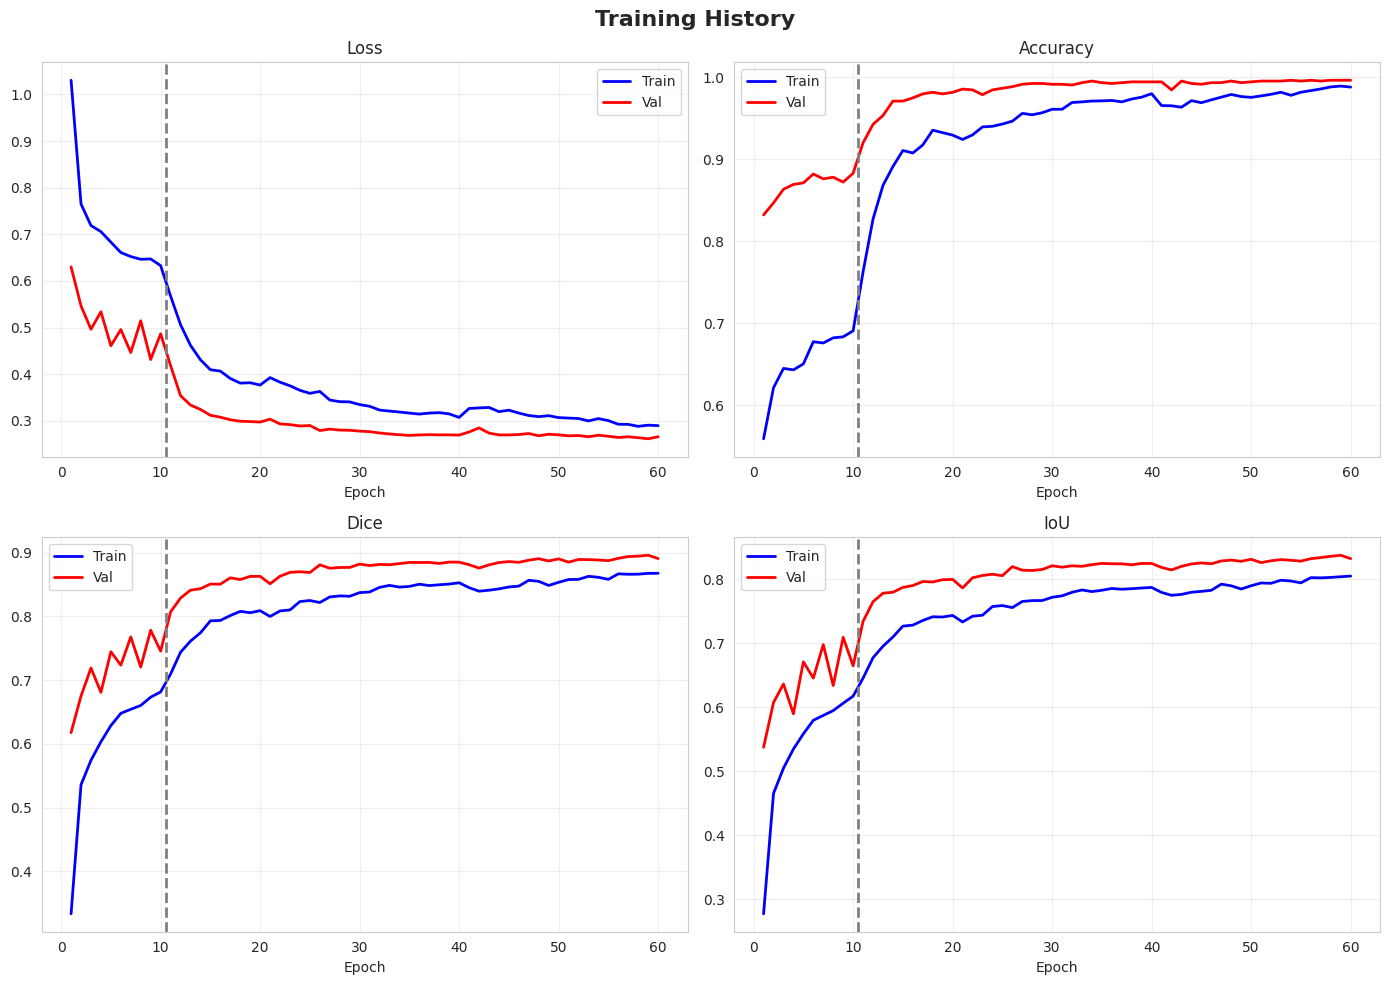

Stage 1: 10 epochs | Stage 2: 50 epochs
Best Val IoU: 0.8378


In [14]:
def plot_combined_history(history1, history2):
    """Plot Stage 1 + Stage 2 with vertical separator"""
    train_all = history1['train'] + history2['train']
    val_all = history1['val'] + history2['val']
    epochs = range(1, len(train_all) + 1)
    stage1_end = len(history1['train'])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    metrics = [('loss', 'Loss'), ('acc', 'Accuracy'), ('dice', 'Dice'), ('iou', 'IoU')]
    
    for ax, (key, name) in zip(axes.flat, metrics):
        train_vals = [m[key] for m in train_all]
        val_vals = [m[key] for m in val_all]
        
        ax.plot(epochs, train_vals, 'b-', label='Train', lw=2)
        ax.plot(epochs, val_vals, 'r-', label='Val', lw=2)
        
        # Vertical separator line
        ax.axvline(x=stage1_end + 0.5, color='gray', linestyle='--', lw=2)
        
        ax.set_title(name, fontsize=12)
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Stage 1: {stage1_end} epochs | Stage 2: {len(history2['train'])} epochs")
    print(f"Best Val IoU: {max(m['iou'] for m in val_all):.4f}")

plot_combined_history(history1, history2)


## 10. Evaluation

In [15]:
# Load best model
ckpt = torch.load('best_final.pth', map_location=Config.DEVICE)
model.load_state_dict(ckpt['model'])
print(f"Loaded best model (IoU: {ckpt['iou']:.4f}, Dice: {ckpt['dice']:.4f})")

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    y_true_cls, y_pred_cls, y_true_seg, y_pred_seg = [], [], [], []
    for imgs, masks, labels in tqdm(loader, desc="Predicting"):
        imgs = imgs.to(device)
        pred_m, pred_c = model(imgs)
        y_true_cls.extend(labels.numpy())
        y_pred_cls.extend(torch.argmax(pred_c, dim=1).cpu().numpy())
        y_true_seg.append(masks)
        y_pred_seg.append((torch.sigmoid(pred_m) > 0.5).float().cpu())
    return np.array(y_true_cls), np.array(y_pred_cls), torch.cat(y_true_seg), torch.cat(y_pred_seg)

y_true_cls, y_pred_cls, y_true_seg, y_pred_seg = get_predictions(model, test_loader, Config.DEVICE)

Loaded best model (IoU: 0.8378, Dice: 0.8958)


Predicting: 100%|██████████| 1000/1000 [00:23<00:00, 41.87it/s]



CLASSIFICATION EVALUATION
              precision    recall  f1-score   support

      glioma     0.9883    0.9961    0.9922       254
  meningioma     0.9934    0.9869    0.9902       306
    no_tumor     1.0000    1.0000    1.0000       140
   pituitary     0.9967    0.9967    0.9967       300

    accuracy                         0.9940      1000
   macro avg     0.9946    0.9949    0.9947      1000
weighted avg     0.9940    0.9940    0.9940      1000



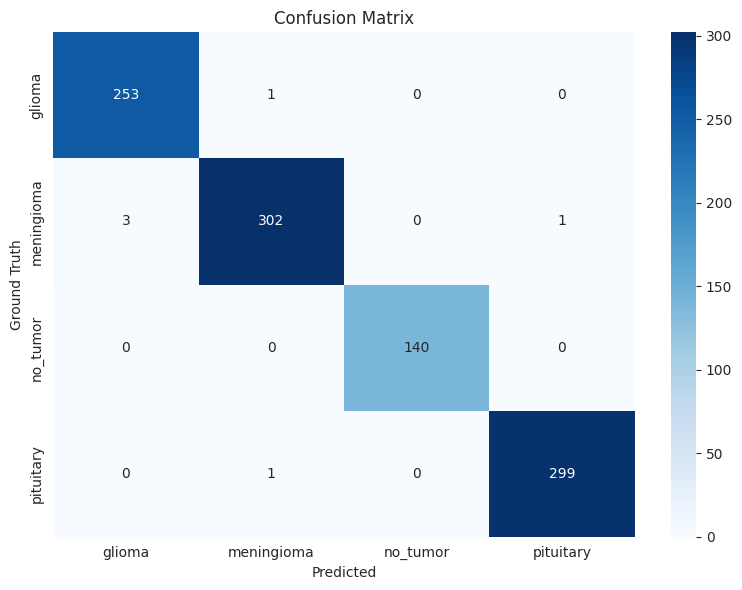

In [16]:
# Classification Report
print("\n" + "="*50 + "\nCLASSIFICATION EVALUATION\n" + "="*50)
print(classification_report(y_true_cls, y_pred_cls, target_names=Config.CLASSES, digits=4))

cm = confusion_matrix(y_true_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Config.CLASSES, yticklabels=Config.CLASSES)
plt.xlabel('Predicted'); plt.ylabel('Ground Truth'); plt.title('Confusion Matrix')
plt.tight_layout(); plt.show()


SEGMENTATION EVALUATION
Mean IoU: 0.8158 | Std: 0.2073
Min: 0.0000 | Max: 1.0000


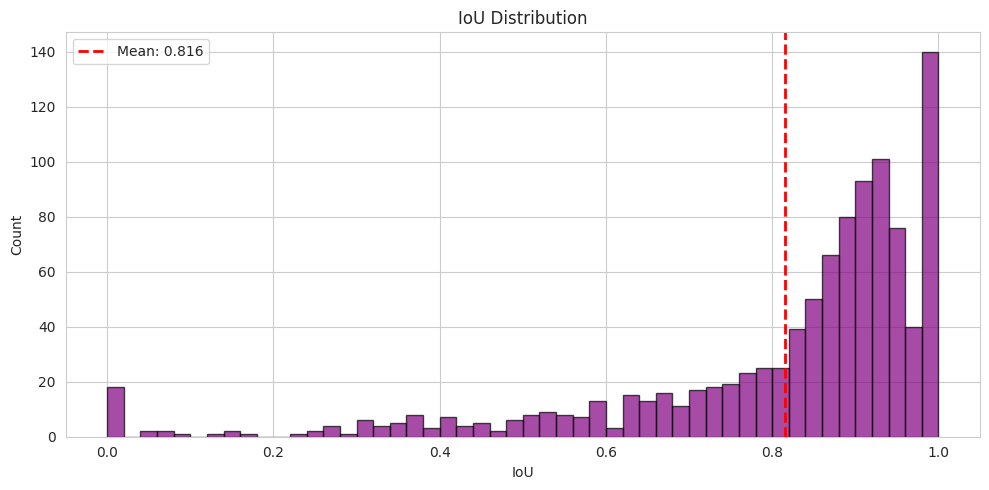

In [17]:
# Segmentation Evaluation
print("\n" + "="*50 + "\nSEGMENTATION EVALUATION\n" + "="*50)
iou_scores = []
for i in range(y_true_seg.shape[0]):
    t, p = y_true_seg[i].view(-1), y_pred_seg[i].view(-1)
    inter = (p * t).sum().item()
    union = p.sum().item() + t.sum().item() - inter
    iou_scores.append((inter + 1e-6) / (union + 1e-6))

iou_scores = np.array(iou_scores)
print(f"Mean IoU: {np.mean(iou_scores):.4f} | Std: {np.std(iou_scores):.4f}")
print(f"Min: {np.min(iou_scores):.4f} | Max: {np.max(iou_scores):.4f}")

plt.figure(figsize=(10, 5))
plt.hist(iou_scores, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(iou_scores), color='r', linestyle='--', lw=2, label=f'Mean: {np.mean(iou_scores):.3f}')
plt.xlabel('IoU'); plt.ylabel('Count'); plt.title('IoU Distribution'); plt.legend()
plt.tight_layout(); plt.show()

Pixel Accuracy: 0.9967
Tumor IoU: 0.8181
Dice Score: 0.9000


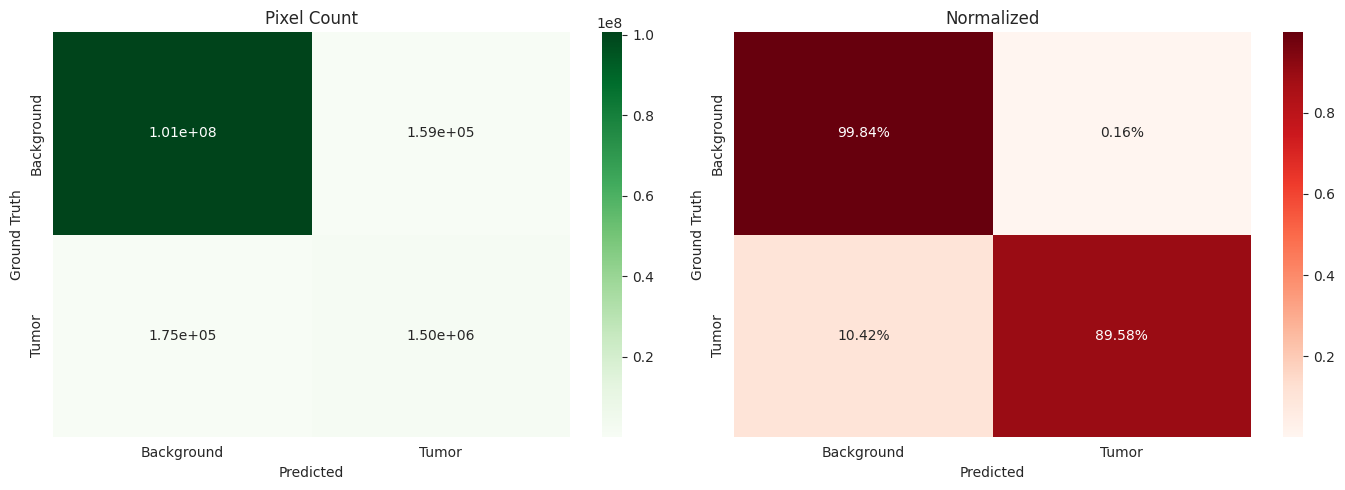

In [18]:
# Pixel-level Confusion Matrix
t_flat, p_flat = y_true_seg.view(-1), y_pred_seg.view(-1)
TP = ((p_flat == 1) & (t_flat == 1)).sum().item()
TN = ((p_flat == 0) & (t_flat == 0)).sum().item()
FP = ((p_flat == 1) & (t_flat == 0)).sum().item()
FN = ((p_flat == 0) & (t_flat == 1)).sum().item()

print(f"Pixel Accuracy: {(TP+TN)/(TP+TN+FP+FN):.4f}")
print(f"Tumor IoU: {TP/(TP+FP+FN+1e-6):.4f}")
print(f"Dice Score: {2*TP/(2*TP+FP+FN+1e-6):.4f}")

cm_px = np.array([[TN, FP], [FN, TP]])
cm_norm = cm_px.astype('float') / cm_px.sum(axis=1, keepdims=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
labels = ['Background', 'Tumor']
sns.heatmap(cm_px, annot=True, fmt='.2e', cmap='Greens', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title('Pixel Count'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Ground Truth')
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title('Normalized'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Ground Truth')
plt.tight_layout(); plt.show()

## 11. Sample Predictions

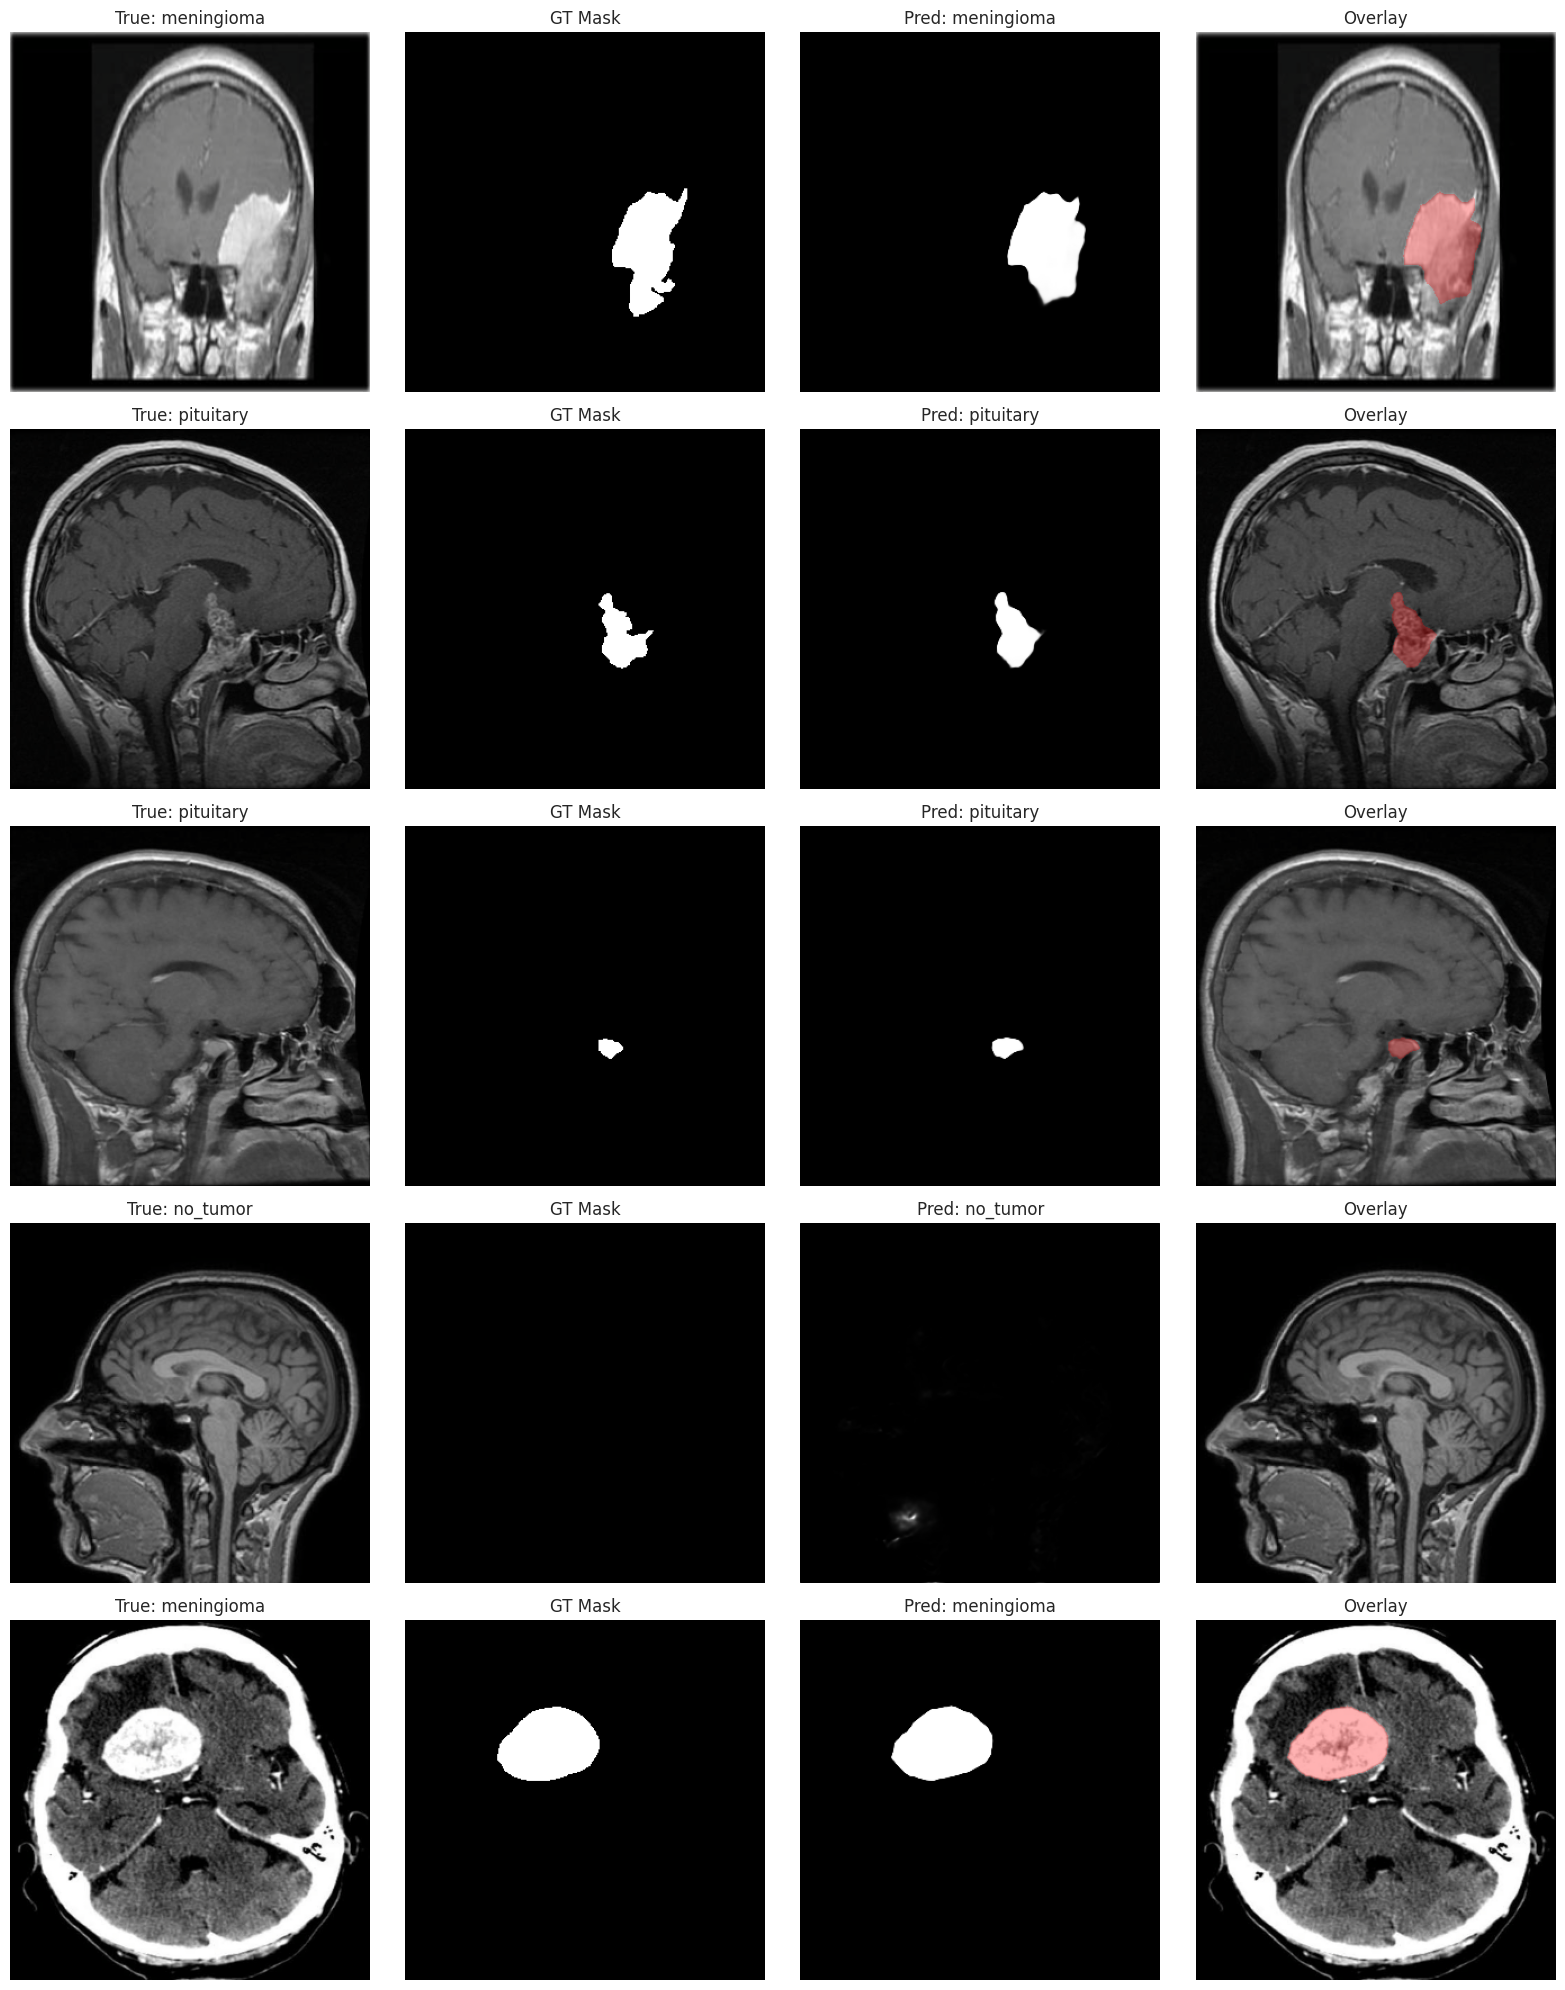

In [19]:
def visualize_samples(model, dataset, device, n=5):
    model.eval()
    indices = np.random.choice(len(dataset), n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    mean, std = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    
    for i, idx in enumerate(indices):
        img, mask, label = dataset[idx]
        with torch.no_grad():
            pred_m, pred_c = model(img.unsqueeze(0).to(device))
            pred_m = torch.sigmoid(pred_m).cpu().squeeze()
            pred_label = torch.argmax(pred_c, dim=1).item()
        
        img_show = np.clip((img * std + mean).permute(1,2,0).numpy(), 0, 1)
        axes[i,0].imshow(img_show); axes[i,0].set_title(f"True: {Config.CLASSES[label]}"); axes[i,0].axis('off')
        axes[i,1].imshow(mask.squeeze(), cmap='gray'); axes[i,1].set_title("GT Mask"); axes[i,1].axis('off')
        axes[i,2].imshow(pred_m, cmap='gray'); axes[i,2].set_title(f"Pred: {Config.CLASSES[pred_label]}"); axes[i,2].axis('off')
        overlay = img_show.copy(); overlay[pred_m > 0.5] = [1, 0, 0]
        axes[i,3].imshow(np.clip(0.7*img_show + 0.3*overlay, 0, 1)); axes[i,3].set_title("Overlay"); axes[i,3].axis('off')
    plt.tight_layout(); plt.show()

test_dataset = BRISCDataset(test_df, get_val_transforms(Config.IMG_SIZE))
visualize_samples(model, test_dataset, Config.DEVICE, n=5)

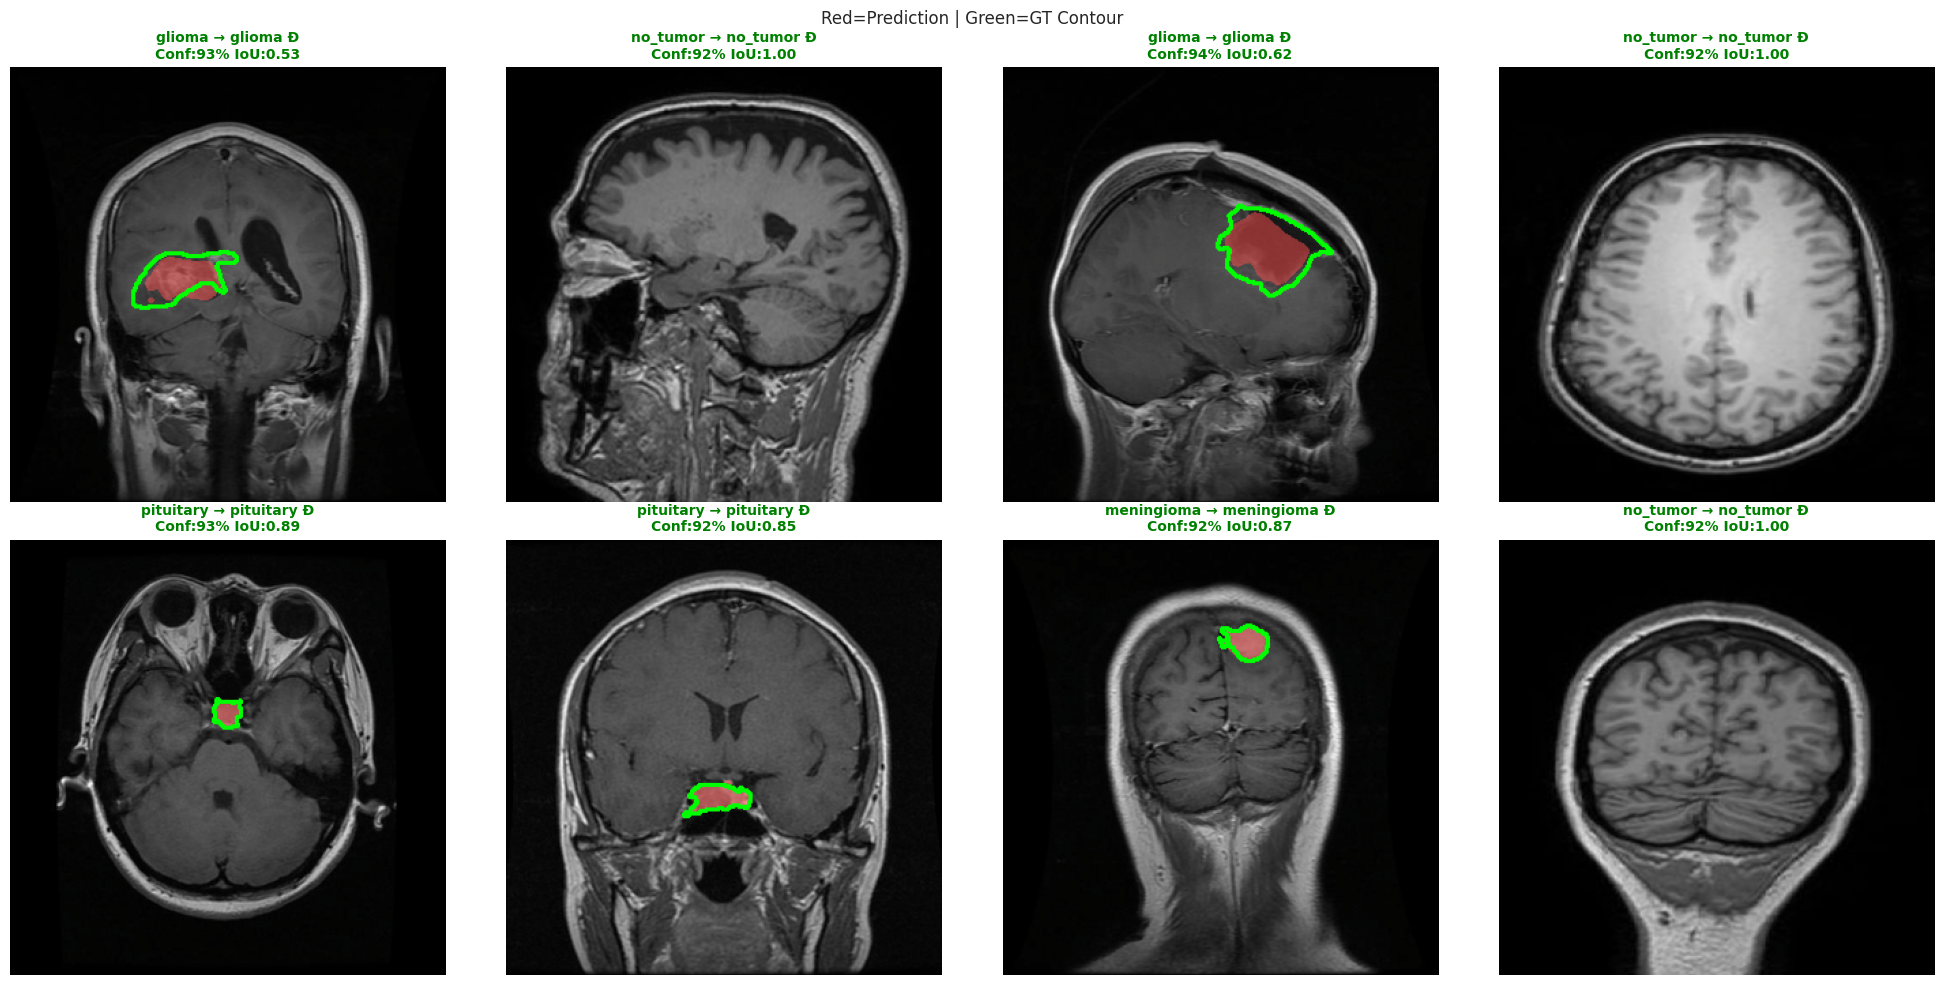

In [20]:
def visualize_results(model, dataset, device, n=8):
    """Visualize segmentation + classification results"""
    model.eval()
    mean, std = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    indices = np.random.choice(len(dataset), n, replace=False)
    
    cols, rows = 4, (n + 3) // 4
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, idx in enumerate(indices):
        img, mask, label = dataset[idx]
        with torch.no_grad():
            pred_m, pred_c = model(img.unsqueeze(0).to(device))
            pred_prob = torch.sigmoid(pred_m).cpu().squeeze().numpy()
            pred_label = torch.argmax(pred_c, dim=1).item()
            conf = torch.softmax(pred_c, dim=1).max().item()
        
        img_np = np.clip((img * std + mean).permute(1,2,0).numpy(), 0, 1)
        gt_mask, pred_mask = mask.squeeze().numpy(), (pred_prob > 0.5)
        
        # Overlay: pred=red, gt_contour=green
        overlay = img_np.copy()
        overlay[pred_mask] = overlay[pred_mask] * 0.5 + np.array([1, 0.3, 0.3]) * 0.5
        
        # GT contour using cv2
        if gt_mask.sum() > 0:
            contours, _ = cv2.findContours((gt_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours((overlay * 255).astype(np.uint8), contours, -1, (0, 255, 0), 2)
            for c in contours:
                cv2.drawContours(overlay, [c], -1, (0, 1, 0), 2)
        
        # IoU
        inter = (pred_mask * gt_mask).sum()
        iou = (inter + 1e-6) / (pred_mask.sum() + gt_mask.sum() - inter + 1e-6)
        
        axes[i].imshow(np.clip(overlay, 0, 1))
        ok = "Đ" if pred_label == label.item() else "Sai"
        axes[i].set_title(f"{Config.CLASSES[label]} → {Config.CLASSES[pred_label]} {ok}\nConf:{conf:.0%} IoU:{iou:.2f}", 
                         fontsize=10, color="green" if ok=="Đ" else "red", fontweight='bold')
        axes[i].axis('off')
    
    for j in range(i+1, len(axes)): axes[j].axis('off')
    plt.suptitle('Red=Prediction | Green=GT Contour', fontsize=12)
    plt.tight_layout(); plt.show()

test_dataset = BRISCDataset(test_df, get_val_transforms(Config.IMG_SIZE))
visualize_results(model, test_dataset, Config.DEVICE, n=8)
